In [1]:
import os
import sys
from copy import deepcopy
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import pandas as pd
import pickle

sns.set(style='whitegrid', rc={
    'figure.figsize':(12,8),
    'legend.fontsize': 'large',
    'legend.title_fontsize': 'large',
    'axes.labelsize': 'large',
    'axes.titlesize':'large',
    'xtick.labelsize':'large',
    'ytick.labelsize':'large',
    'font.family': 'sans-serif',
    'font.sans-serif': 'Lucida Grande'
})

from utils import compare
from envs import DiscreteBanditEnv

def filter_df(df, **kwargs):
    for k,v in kwargs.items():
        df = df[df[k] == v]
    return df

In [2]:
%matplotlib inline

In [3]:
def filter_df(df, **kwargs):
    for k,v in kwargs.items():
        df = df[df[k] == v]
    return df

# Figure 9

In [ ]:
data_dict = {}
stats_dict = {}
n_iter = 50
for action_dim in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    avg_rewards = 0.1 * np.random.randn(action_dim)
    n_nonzero_actions = int(action_dim / 2)
    avg_rewards[:n_nonzero_actions] = 0.1 * np.random.randn(n_nonzero_actions) + 0.5
    avg_rewards[0] = 1
    env = DiscreteBanditEnv(avg_rewards=avg_rewards)
    data_dict[action_dim] = compare(env, 'discrete', n_steps=n_iter, repeats=20,
                                    lr=1e-1, batch_size=32, num_minibatches=1, ppo_epochs=10)
    last_iter = deepcopy(filter_df(data_dict[action_dim], iter=n_iter-1))
    last_iter['subopt_prob'] = last_iter[[
        f'pd_param_{i}_mean' for i in range(1, n_nonzero_actions)]].sum(axis=1)
    last_iter['stuck'] = (last_iter.subopt_prob > 0.95)
    last_iter['converge'] = (last_iter.pd_param_0_mean > 0.95)
    stats_dict[action_dim] = last_iter[['method', 'stuck', 'converge']].groupby('method').mean()

In [ ]:
with open('discrete_100actions.pkl', 'wb') as f:
    pickle.dump(data_dict, f)

In [ ]:
frames = []
for k, df in stats_dict.items():
    df['action_dim'] = k
    frames.append(df)
stats_combined = pd.concat(frames, axis=0).reset_index()
stats_combined = stats_combined[stats_combined.method != 'Unregularized']
stats_combined = stats_combined.sort_values(by='method', ascending=False)
    
with open('discrete_100actions_stats.pkl', 'wb') as f:
    pickle.dump(stats_combined, f)

In [4]:
with open('discrete_100actions.pkl', 'rb') as f:
    data_dict = pickle.load(f)
with open('discrete_100actions_stats.pkl', 'rb') as f:
    stats_combined = pickle.load(f)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


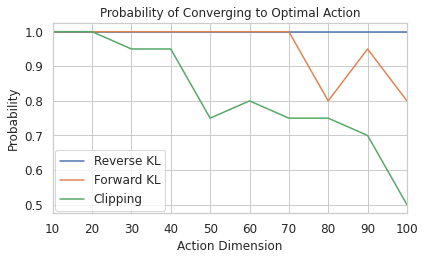

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
fig.subplots_adjust(right=0.74)
sns.lineplot(data=stats_combined.reset_index(), x='action_dim', y='converge', hue='method', markers=['x'], ax=ax)
plt.xlabel('Action Dimension')
plt.ylabel('Probability')
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
ax.set_xlim([10,100])
fig.legend(handles[1:], labels[1:], loc=(0.13,0.19), ncol=1)
plt.title('Probability of Converging to Optimal Action')
plt.show()

# Figure 10

/home/eecs/chloehsu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


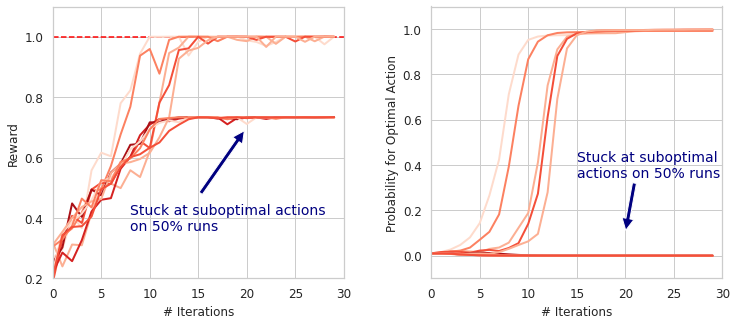

In [6]:
clip_data = filter_df(data_dict[100], method='Clipping')

sns.set_palette("Reds")
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].set_ylabel('Reward')
for i in range(10):
    sns.lineplot(data=clip_data[i*50:i*50+30], x='iter', y='pd_param_0_mean', ax=ax[1], lw=2, alpha=1,
             legend=False, ci=None)
    sns.lineplot(data=clip_data[i*50:i*50+30], x='iter', y='mean_reward', ax=ax[0], lw=2, alpha=1,
             legend=False, ci=None)
ax[1].set_ylabel('Probability for Optimal Action')
ax[1].set_ylim([-0.1, 1.1])
clip_data['subopt_prob'] = clip_data[[f'pd_param_{i}_mean' for i in range(1,50)]].sum(axis=1)
for a in ax:
    a.set_xlabel('# Iterations')
    a.set_xlim([0,30])
ax[0].set_ylim([0.2, 1.1])
ax[0].set_ylabel('Reward')
fig.subplots_adjust(wspace=0.3)

from matplotlib.lines import Line2D
ax[0].hlines(1.0, 0, 30, colors='red', linestyles='dashed')
blackline = Line2D([0], [0], color='red', ls='dashed', lw=2, label='Optimal Reward')
greenline = Line2D([0], [0], color='green', ls='solid', lw=2, label='PPO w/ clipped obj')
#fig.legend(handles=[blackline, greenline], loc='upper center', ncol=2)


ax[1].text(15, 0.4, "Stuck at suboptimal\nactions on 50% runs", ha="left", va="center", size=14, color='navy')
ax[1].annotate('', xy=(20, 0.1),  xycoords='data',
            xytext=(0.7, 0.36), textcoords='axes fraction',
            arrowprops=dict(facecolor='navy', shrink=0.05),
            horizontalalignment='right', verticalalignment='top',
            )
ax[0].text(8, 0.4, "Stuck at suboptimal actions\non 50% runs", ha="left", va="center", size=14, color='navy')
ax[0].annotate('', xy=(20, 0.7),  xycoords='data',
            xytext=(0.5, 0.3), textcoords='axes fraction',
            arrowprops=dict(facecolor='navy', shrink=0.05),
            horizontalalignment='right', verticalalignment='top',
            )


plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


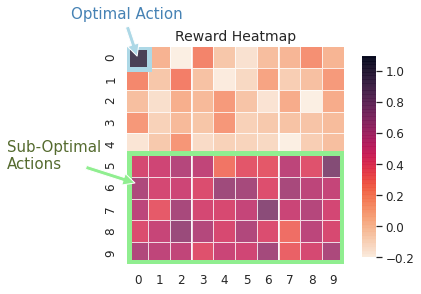

In [7]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
rewards = np.random.randn(10,10) * 0.1
rewards[5:, :] += 0.5
rewards[0,0] = 1.0
cbar_ax = fig.add_axes([.95, .15, .05, .7])
ax.set_title('Reward Heatmap', fontsize=14)
sns.heatmap(rewards, ax=ax, square=True, cmap=sns.cm.rocket_r, linewidths=.1, vmin=-0.2, vmax=1.1, cbar_ax=cbar_ax, alpha=0.8)
from matplotlib import patches
rect = patches.Rectangle((0,0),1,1,linewidth=5,edgecolor='lightblue',facecolor='none')
ax.add_patch(rect)
ax.text(0, -1.5, "Optimal Action", ha="center", va="center", size=15, color='steelblue')
ax.annotate('', xy=(0.5, 0.5),  xycoords='data',
            xytext=(0, 1.1), textcoords='axes fraction',
            arrowprops=dict(facecolor='lightblue', shrink=0.05),
            horizontalalignment='right', verticalalignment='top',
            )

rect = patches.Rectangle((0.1,4.89),9.8,5,linewidth=5,edgecolor='lightgreen',facecolor='none')
ax.text(-5.5, 5, "Sub-Optimal\nActions", ha="left", va="center", size=15, color='darkolivegreen')
ax.annotate('', xy=(0.5, 6.3),  xycoords='data',
            xytext=(-0.2, 0.45), textcoords='axes fraction',
            arrowprops=dict(facecolor='lightgreen', shrink=0.05),
            horizontalalignment='right', verticalalignment='top',
            )

ax.add_patch(rect)
plt.show()